In [1]:
import string
import re
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import string
import re
import nltk
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
#newStopWords = ['from','dtype','object']
#stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

In [3]:
# load doc into memory
def load_file(filename):
    df = pd.read_excel(filename)
    df.fillna('NA', inplace=True)
    return df

In [39]:
def clean_doc(doc):
	# split into tokens by white space
    doc = doc.replace('\n',' ')
    tokens = doc.split()
	# prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
	# remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
	# remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
    tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [5]:
# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
	# load doc
    df = load_file(filename)
    #selecting set of columns as Features
    features_df=df[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient']]
    # clean doc 
    for i in range (len(features_df.columns)):
        col = features_df.columns.get_values()[i]
        tokens = clean_doc(str(features_df[col].values))
        vocab.update(tokens)

In [6]:
# save list to file
def save_list(lines, filename):
	# convert lines to a single blob of text
	data = '\n'.join(lines)
	# open file
	file = open(filename, 'w')
	# write text
	file.write(data)
	# close file
	file.close()

# Create vocab by tokenizing all rows and adding tokens to Vocab

In [73]:
# define vocab
vocab = Counter()
# create vocab
add_doc_to_vocab("/home/anirban/Downloads/FSHA - RPA.xlsm",vocab)
#print length of vocab
print(len(vocab))
# keep tokens with a min occurrence
min_occurance = 2
tokens = [k for k,c in vocab.items() if c >= min_occurance]
print(len(tokens))
print(tokens)
# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

250
124
['None', 'NA', 'Sodium', 'acetates', 'acetate', 'ii', 'hydrogen', 'sodium', 'diacetate', 'ingredients', 'TBC', 'na', 'preservatives', 'present', 'seasoning', 'Not', 'applicable', 'max', 'low', 'moisture', 'food', 'Pellet', 'Finished', 'Product', 'Low', 'modified', 'atmosphere', 'Nitrogen', 'flushed', 'WIP', 'packaging', 'month', 'standard', 'shelf', 'life', 'pellet', 'nitrogen', 'Moisture', 'Content', 'Store', 'dry', 'cool', 'away', 'sun', 'place', 'Ambient', 'RTE', 'ambient', 'none', 'claims', 'No', 'People', 'allergies', 'milk', 'lactose', 'peanuts', 'Suitable', 'consumers', 'potential', 'choking', 'hazard', 'younger', 'children', 'Yes', 'change', 'current', 'product', 'allergens', 'McCormick', 'Cheese', 'may', 'contain', 'manufacturing', 'plant', 'celery', 'cereals', 'containing', 'gluten', 'wheat', 'barley', 'mustard', 'soyanExisting', 'production', 'line', 'soya', 'Playz', 'Cereals', 'Gluten', 'Milk', 'Salsa', 'Soya', 'BBQ', 'Twistz', 'Spicy', 'Chutney', 'SulphitesnnCross'

In [74]:
def process_data_to_lines(df, vocab):
    lines = list()
    for i in range(len(df)):
        tokens = clean_doc(str(df.iloc[i,:].values))
	# filter by vocab
        tokens = [w for w in tokens if w in vocab]
        tokens = ' '.join(tokens)
        lines.append(tokens)
    return lines

In [75]:
# fit a tokenizer
from keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [76]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# Load vocabulary into memory

In [77]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())

In [78]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if str(fsha_data[targetName][i]).strip().lower() =='yes':
            train_y.append(1)
        elif str(fsha_data[targetName][i]).strip().lower() =='no':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

# Read data, impute target with mode, impute X with NA, do train test split

In [79]:
# load all data
from sklearn.model_selection import train_test_split 
filename = "/home/anirban/Downloads/FSHA - RPA.xlsm"
df = pd.read_excel(filename)
df.fillna('NA', inplace=True)
X = df[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient']]
y = impute_target(df,"potentialMicrobial")

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

In [81]:
X_train.iloc[0,:].values

array(['na', 'na', 0.2, 'na', 'None ', 'silo', 'na', 'Same as current',
       'All current suppliers to PepsiCo have cross contaminated maize, so Regulatory will lead a project to ensure all products using maize will need to carry this warning in the future. Ruth is aligned that film for the trial and for the Maize Grits project does not have to be changed.  ',
       'No'], dtype=object)

# From the Train and test data create encoded matrix with keras.preprocessing.text.Tokenizer

In [82]:
train_docs = process_data_to_lines(X_train,vocab)
test_docs = process_data_to_lines(X_test,vocab)

In [85]:
train_docs[7]

'None na Pellet Finished Product Nitrogen flushed Moisture Content Pellet Ambient na Suitable consumers potential choking hazard younger children Playz Cereals containing Gluten Milk Salsa Playz Cereals containing Gluten Soya BBQ Twistz Cereals containing Gluten Milk Soya Spicy Chutney Twistz Cereals containing Gluten Milk Soya SulphitesnnCross Playz Salsa Playz BBQ Twistz Spicy Chutney Twistz None Yes'

In [86]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

In [87]:
# encode data
Xtrain,ytrain = tokenizer.texts_to_matrix(train_docs, mode='freq'),y_train
Xtest,ytest = tokenizer.texts_to_matrix(test_docs, mode='freq'),y_test
print(Xtrain.shape, Xtest.shape)

(10, 102) (3, 102)


In [88]:
Xtrain[0]

array([0.        , 0.33333333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.08333333, 0.        , 0.        , 0.        ,
       0.08333333, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.16666667, 0.16666667, 0.16666667,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [89]:
ytrain

[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]

# Define neural network model

In [60]:
# define the model
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
def define_model(n_words):
	# define network
	model = Sequential()
	model.add(Dense(50, input_shape=(n_words,), activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# compile network
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize defined model
	model.summary()
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

# Fit model and evaluate

In [61]:
n_words = Xtest.shape[1]
model = define_model(n_words)
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                5250      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 0s - loss: 0.6960 - acc: 0.3000
Epoch 2/10
 - 0s - loss: 0.6940 - acc: 0.4000
Epoch 3/10
 - 0s - loss: 0.6915 - acc: 0.4000
Epoch 4/10
 - 0s - loss: 0.6891 - acc: 0.8000
Epoch 5/10
 - 0s - loss: 0.6869 - acc: 0.9000
Epoch 6/10
 - 0s - loss: 0.6846 - acc: 0.9000
Epoch 7/10
 - 0s - loss: 0.6822 - acc: 0.9000
Epoch 8/10
 - 0s - loss: 0.6799 - acc: 0.9000
Epoch 9/10
 - 0s - loss: 0.6776 - acc: 0.9000
Epoch 10/10
 - 0s - loss: 0.6754 - acc: 0.9000
Test Accuracy: 100.000000


# Use 4 diff modes to encode documents (tf-idf, freq, count, binary) and compare results

In [67]:
# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, y_train,y_test, mode):
	# create the tokenizer
	tokenizer = Tokenizer()
	# fit the tokenizer on the documents
	tokenizer.fit_on_texts(train_docs)
	# encode training data set
	Xtrain, ytrain = tokenizer.texts_to_matrix(train_docs, mode=mode),y_train
	# encode training data set
	Xtest, ytest = tokenizer.texts_to_matrix(test_docs, mode=mode),y_test
	return Xtrain, Xtest, ytrain, ytest

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
# load all reviews
train_docs = process_data_to_lines(X_train,vocab)
test_docs = process_data_to_lines(X_test,vocab)


In [71]:
# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
	scores = list()
	n_repeats = 10
	n_words = Xtest.shape[1]
	for i in range(n_repeats):
		# define network
		model = define_model(n_words)
		# fit network
		model.fit(Xtrain, ytrain, epochs=10, verbose=0)
		# evaluate
		_, acc = model.evaluate(Xtest, ytest, verbose=0)
		scores.append(acc)
		print('%d accuracy: %s' % ((i+1), acc))
	return scores

(10, 104)
(3, 104)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                5250      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 1.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                5250      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________
2 accuracy: 1.0
_____________________

4 accuracy: 1.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 50)                5250      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 51        
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________
5 accuracy: 1.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 50)                5250      
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 51        
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________
6 accuracy: 0.6666666865348816
_________

8 accuracy: 1.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 50)                5250      
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 51        
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________
9 accuracy: 0.3333333432674408
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 50)                5250      
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 51        
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________
10 accuracy: 0.6666666865

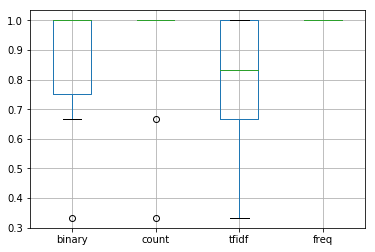

In [72]:
# run experiment
from pandas import DataFrame
from matplotlib import pyplot
%matplotlib inline
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
	# prepare data for mode
    Xtrain, Xtest, ytrain, ytest = prepare_data(train_docs, test_docs, y_train,y_test, mode)
    print(Xtrain.shape)
    #print(ytrain.shape)
    print(Xtest.shape)
    #print(ytest.shape)
	# evaluate model on data for mode
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)
# summarize results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()